In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Correct Kaggle paths
train = pd.read_csv("/kaggle/input/playground-series-s5e9/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e9/test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()


Train shape: (524164, 11)
Test shape: (174722, 10)


,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


In [16]:
print(train.info())
print(train.describe().T)

print("Missing values in train:\n", train.isnull().sum().sort_values(ascending=False).head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         524164 non-null  int64  
 1   RhythmScore                524164 non-null  float64
 2   AudioLoudness              524164 non-null  float64
 3   VocalContent               524164 non-null  float64
 4   AcousticQuality            524164 non-null  float64
 5   InstrumentalScore          524164 non-null  float64
 6   LivePerformanceLikelihood  524164 non-null  float64
 7   MoodScore                  524164 non-null  float64
 8   TrackDurationMs            524164 non-null  float64
 9   Energy                     524164 non-null  float64
 10  BeatsPerMinute             524164 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 44.0 MB
None
                              count           mean            std  \
id                    

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


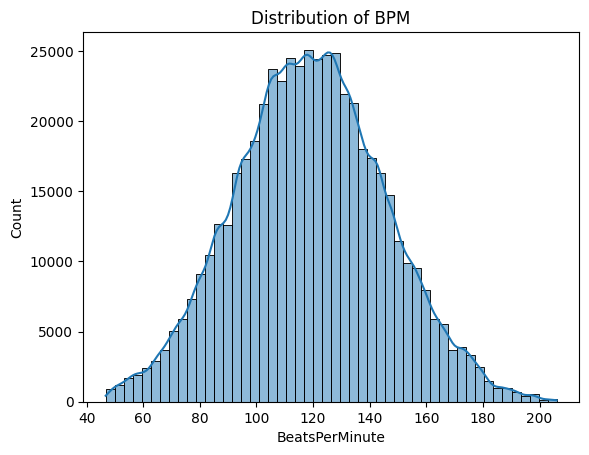

In [17]:
sns.histplot(train["BeatsPerMinute"], bins=50, kde=True)
plt.title("Distribution of BPM")
plt.show()

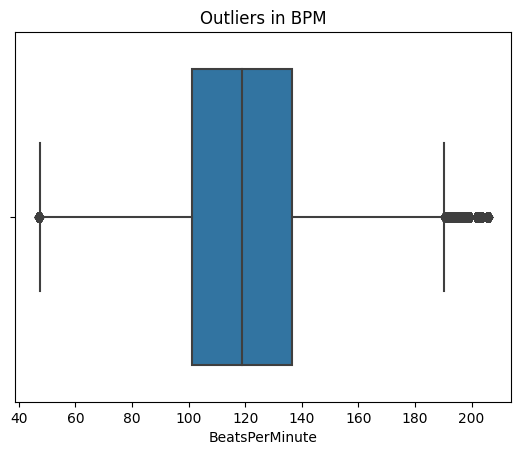

In [18]:
# Boxplot for outliers
sns.boxplot(x=train["BeatsPerMinute"])
plt.title("Outliers in BPM")
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


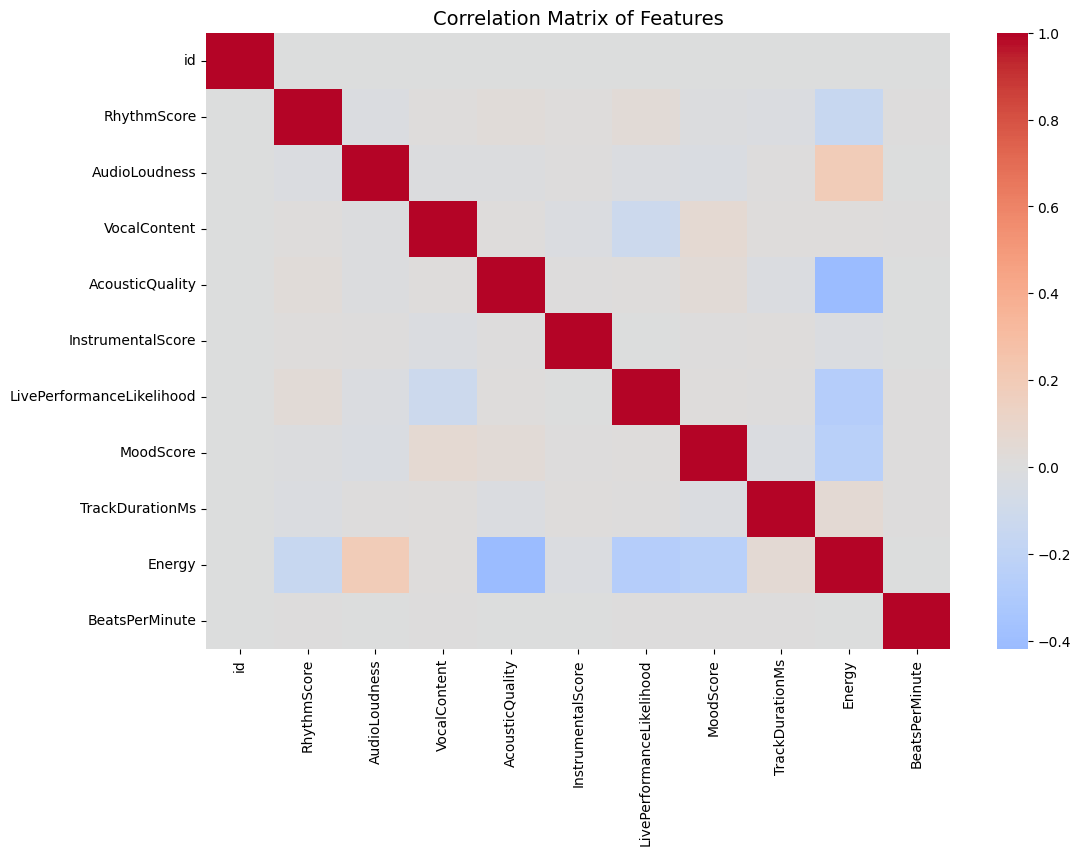

In [19]:
corr = train.corr(numeric_only=True)

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, fmt=".2f")
plt.title("Correlation Matrix of Features", fontsize=14)
plt.show()

In [20]:
#Removing outliers
train = train[(train["BeatsPerMinute"] > 40) & (train["BeatsPerMinute"] < 250 )]

In [21]:
for col in train.select_dtypes(include=[float, int]).columns:
    train[col] = train[col].fillna(train[col].median())
for col in test.select_dtypes(include=[float, int]).columns:
    test[col] = test[col].fillna(test[col].median())

for col in train.select_dtypes(include=['object']).columns:
    train[col] = train[col].fillna(train[col].mode()[0])
for col in test.select_dtypes(include=['object']).columns:
    test[col] = test[col].fillna(test[col].mode()[0])

In [22]:
X = train.drop(columns=["id", "BeatsPerMinute"])
y = train["BeatsPerMinute"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train set:", X_train.shape, "Validation set:", X_val.shape)

Train set: (419331, 9) Validation set: (104833, 9)


In [23]:
def evaluate_model(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📈 {name} Performance:")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.5f}")

In [24]:
# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
lr_pred = lr.predict(X_val)

# Evaluate
evaluate_model(y_val, lr_pred, "Linear Regression") 


📈 Linear Regression Performance:
MAE:  21.1841
RMSE: 26.4439
R²:   0.00009


In [25]:
# Train Decision Tree
dt = DecisionTreeRegressor(max_depth=15, min_samples_leaf=3, random_state=42)
dt.fit(X_train, y_train)

dt_pred = dt.predict(X_val)

evaluate_model(y_val, dt_pred, "Decision Tree")


📈 Decision Tree Performance:
MAE:  21.4857
RMSE: 26.8570
R²:   -0.03139


In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_val)

evaluate_model(y_val, xgb_pred, "StandardScaler")


📈 StandardScaler Performance:
MAE:  21.2016
RMSE: 26.4647
R²:   -0.00148


In [27]:
from sklearn.model_selection import train_test_split
X = train.drop(columns=["id", "BeatsPerMinute"])
y = train["BeatsPerMinute"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Random Forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=5,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)

evaluate_model(y_val, rf_pred, "Random Forest")


📈 Random Forest Performance:
MAE:  21.1820
RMSE: 26.4402
R²:   0.00037


In [28]:
X = train.drop(columns=["id", "BeatsPerMinute"])
y = train["BeatsPerMinute"]
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

param_dist = {
    "n_estimators": [50],      # only 50 → fast
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt"]   # best option for RF
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=3,     # sirf 3 combos → fast
    cv=2,         # 2-fold CV → double speed
    scoring="r2",
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Params:", random_search.best_params_)
print("Best R² Score:", random_search.best_score_)

# Final model with best params
best_rf = random_search.best_estimator_
rf_pred = best_rf.predict(X_val)

evaluate_model(y_val, rf_pred, "Random Forest pro")

Fitting 2 folds for each of 3 candidates, totalling 6 fits
Best Params: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5}
Best R² Score: 0.000467164888775351

📈 Random Forest pro Performance:
MAE:  21.1799
RMSE: 26.4381
R²:   0.00053
